# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the Albumentations transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
    A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    ToTensorV2()
])


In [3]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                       #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
#                                        ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 105060063.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [6]:
# Explore the classes available in CIFAR10 dataset.
classes = train.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# Get the data distribution for all the classes in CIFAR10 dataset.
class_count = {}
for index in train.targets:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [8]:
test_class_to_idx = test.class_to_idx

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
torch.Size([128, 3, 32, 32])
torch.Size([128])


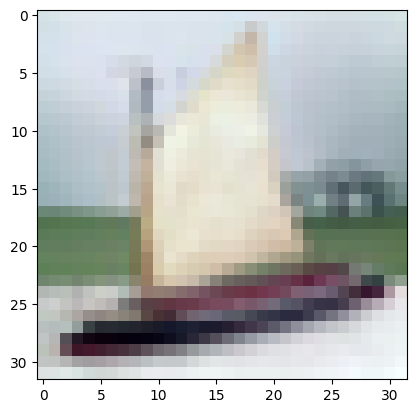

In [9]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
# train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.shape)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

show_image = images[0].numpy().transpose((1,2,0))
# Rescale the pixel values to [0, 1]
show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))

plt.imshow(show_image)


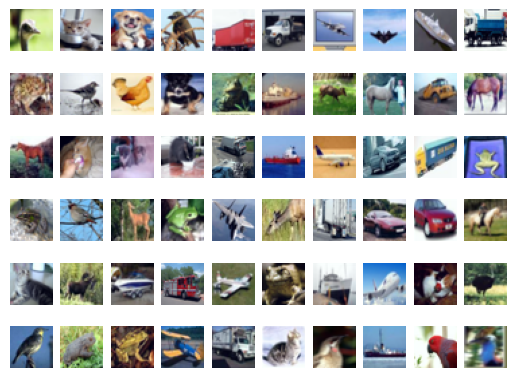

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    show_image = images[index].numpy().transpose((1,2,0))
    # Rescale the pixel values to [0, 1]
    show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))

    plt.imshow(show_image)

# The model
Let's start with the model we first saw

In [11]:
from model import Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(base_channels=100).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 32, 32]             700
       BatchNorm2d-2           [-1, 25, 32, 32]              50
            Conv2d-3           [-1, 50, 32, 32]          11,300
       BatchNorm2d-4           [-1, 50, 32, 32]             100
            Conv2d-5          [-1, 100, 32, 32]          45,100
       BatchNorm2d-6          [-1, 100, 32, 32]             200
           Dropout-7          [-1, 100, 32, 32]               0
            Conv2d-8           [-1, 25, 32, 32]          22,525
       BatchNorm2d-9           [-1, 25, 32, 32]              50
           Conv2d-10           [-1, 50, 30, 30]          11,300
      BatchNorm2d-11           [-1, 50, 30, 30]             100
           Conv2d-12          [-1, 100, 30, 30]          45,100
      BatchNorm2d-13          [-1, 100, 30, 30]             200
          Dropout-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.1075888872146606 Batch_id=390 Accuracy=43.04: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 1.4162, Accuracy: 4990/10000 (49.90%)

EPOCH: 1


Loss=1.0229158401489258 Batch_id=390 Accuracy=61.04: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 1.3412, Accuracy: 5287/10000 (52.87%)

EPOCH: 2


Loss=0.7526835203170776 Batch_id=390 Accuracy=67.90: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]



Test set: Average loss: 1.0488, Accuracy: 6303/10000 (63.03%)

EPOCH: 3


Loss=0.8877426385879517 Batch_id=390 Accuracy=72.07: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]



Test set: Average loss: 0.8749, Accuracy: 6941/10000 (69.41%)

EPOCH: 4


Loss=0.8210121989250183 Batch_id=390 Accuracy=74.74: 100%|██████████| 391/391 [00:31<00:00, 12.31it/s]



Test set: Average loss: 0.8048, Accuracy: 7215/10000 (72.15%)

EPOCH: 5


Loss=0.5802271962165833 Batch_id=390 Accuracy=77.36: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]



Test set: Average loss: 0.8941, Accuracy: 6984/10000 (69.84%)

EPOCH: 6


Loss=0.45937013626098633 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [00:31<00:00, 12.29it/s]



Test set: Average loss: 0.5635, Accuracy: 8053/10000 (80.53%)

EPOCH: 7


Loss=0.4997686445713043 Batch_id=390 Accuracy=83.78: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]



Test set: Average loss: 0.5607, Accuracy: 8061/10000 (80.61%)

EPOCH: 8


Loss=0.5338054895401001 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]



Test set: Average loss: 0.5615, Accuracy: 8047/10000 (80.47%)

EPOCH: 9


Loss=0.45000123977661133 Batch_id=390 Accuracy=84.66: 100%|██████████| 391/391 [00:31<00:00, 12.27it/s]



Test set: Average loss: 0.5512, Accuracy: 8078/10000 (80.78%)

EPOCH: 10


Loss=0.4017031192779541 Batch_id=390 Accuracy=85.09: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]



Test set: Average loss: 0.5427, Accuracy: 8099/10000 (80.99%)

EPOCH: 11


Loss=0.5654168725013733 Batch_id=390 Accuracy=85.49: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 0.5394, Accuracy: 8133/10000 (81.33%)

EPOCH: 12


Loss=0.37783077359199524 Batch_id=390 Accuracy=86.34: 100%|██████████| 391/391 [00:31<00:00, 12.33it/s]



Test set: Average loss: 0.5261, Accuracy: 8181/10000 (81.81%)

EPOCH: 13


Loss=0.46275386214256287 Batch_id=390 Accuracy=86.44: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]



Test set: Average loss: 0.5250, Accuracy: 8184/10000 (81.84%)

EPOCH: 14


Loss=0.3969091773033142 Batch_id=390 Accuracy=86.67: 100%|██████████| 391/391 [00:31<00:00, 12.36it/s]



Test set: Average loss: 0.5247, Accuracy: 8181/10000 (81.81%)

EPOCH: 15


Loss=0.40885454416275024 Batch_id=390 Accuracy=86.69: 100%|██████████| 391/391 [00:31<00:00, 12.31it/s]



Test set: Average loss: 0.5249, Accuracy: 8155/10000 (81.55%)

EPOCH: 16


Loss=0.40623587369918823 Batch_id=390 Accuracy=86.75: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]



Test set: Average loss: 0.5251, Accuracy: 8163/10000 (81.63%)

EPOCH: 17


Loss=0.5104638934135437 Batch_id=390 Accuracy=86.73: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 0.5233, Accuracy: 8173/10000 (81.73%)

EPOCH: 18


Loss=0.465768426656723 Batch_id=390 Accuracy=86.86: 100%|██████████| 391/391 [00:31<00:00, 12.30it/s]



Test set: Average loss: 0.5247, Accuracy: 8186/10000 (81.86%)

EPOCH: 19


Loss=0.42331963777542114 Batch_id=390 Accuracy=86.85: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]



Test set: Average loss: 0.5247, Accuracy: 8168/10000 (81.68%)



Text(0.5, 1.0, 'Test Accuracy')

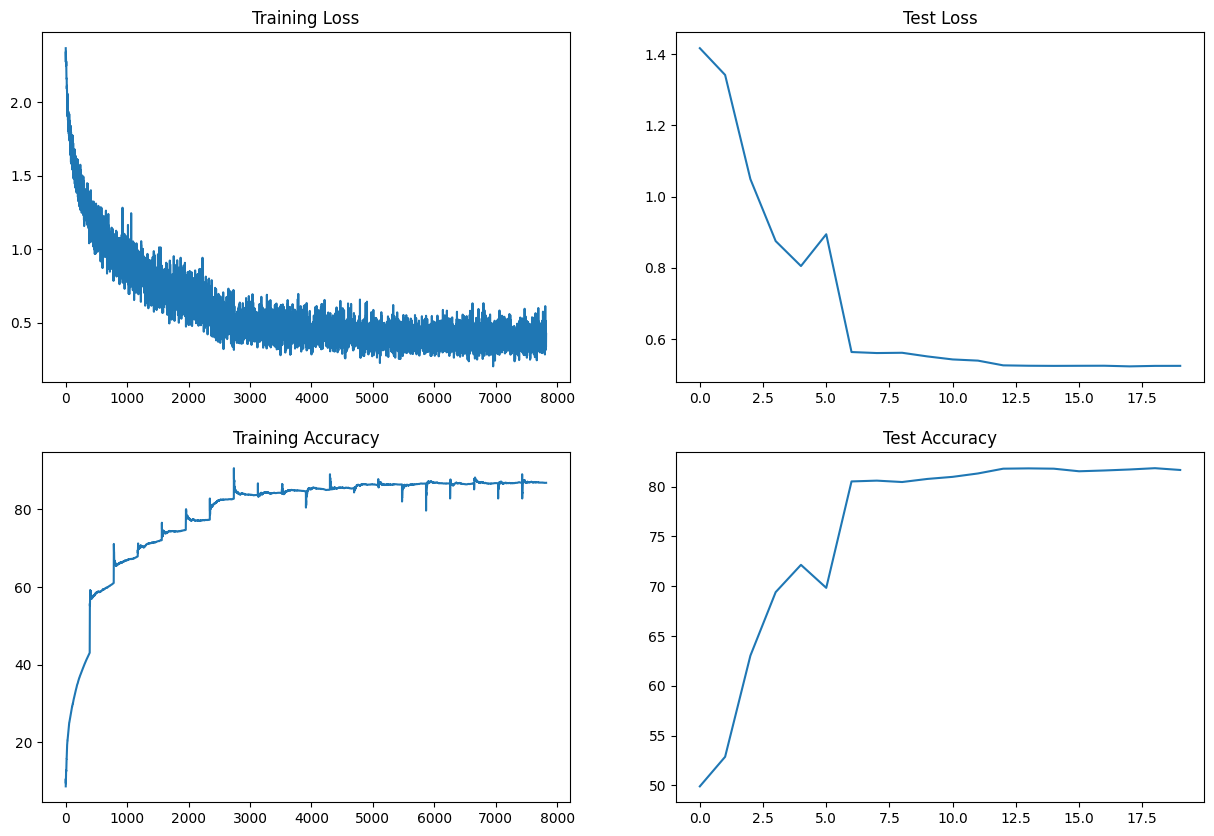

In [15]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
import torch.nn.functional as F
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect


In [17]:
incorrect = get_incorrrect_predictions(model, test_loader, device)

In [18]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.keys())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        show_image = d.cpu().numpy().transpose(1, 2, 0)
        # Rescale the pixel values to [0, 1]
        show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))
        plt.imshow(show_image)
        if i+1 == 5*(count/5):
            break

Total Incorrect Predictions 1832


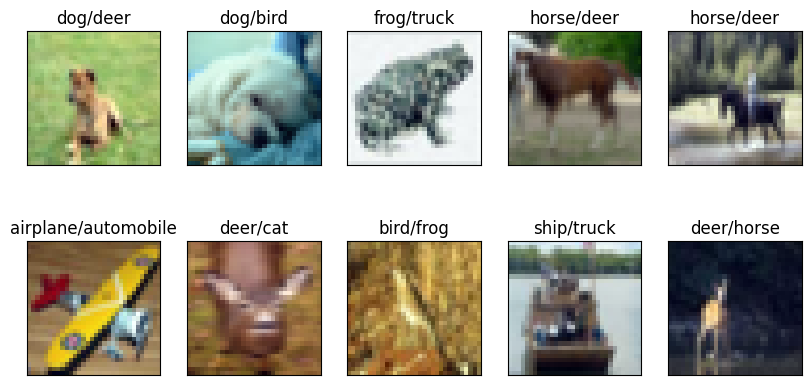

In [19]:
plot_incorrect_predictions(incorrect, test_class_to_idx)